# Imports 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

# Read Images
Pixel values vary from 0 to 255. We work with 0 to 1 for arithmetic efficiency

In [4]:
krishna = imread('krishna.png')/255
krishna_noisy = imread('krishna_0_001.png')/255

## Peak Signal-to-Noise Ratio

The PSNR between $f$ and $\hat{f}$ can be given as $20 log_{10}\left(\frac{MAX_{f}}{\sqrt{MSE}}\right)$. $MAX_f$ is the maximum intensity value in the underlying image and $MSE$ is the mean square distance of the pixel intensities in $f$ and $\hat{f}$.

In [5]:
def PSNR(f,f_hat):
    MAX_f = np.max(f)
    MSE = np.mean((f-f_hat)**2)
    if MSE>0:
        PSNR_val = 20*np.log10(MAX_f/np.sqrt(MSE))
    else:
        PSNR_val = -1
    return PSNR_val

## Image zero padding

In [11]:
def zero_pad_image(image, d):
    x, y, _ = np.shape(image)
    padded_image = np.zeros((x+2*d, y+2*d, 3))
    for i in range(3):
        padded_image[d:-d,d:-d, i] = image[:, :, i]
    return padded_image

# Non-Local Means Filtering

The non-local means filter takes a patch $N_p$ around pixel 'p' and for 'q' in the image and image patch $N_q$ around the same, applies a Gaussian filter that takes to account the value of the intensity of 'q' based on its neighbourhood. Thus the intensity at 'p' can be given as $ g(p) = \frac{1}{Z_{p}}\Sigma_{q\in G_{p}}G_{\sigma}(N_{p}-N_{q})f(q)$. Here $G_p$ is the window in p's neighbourhood of size $(2d+1)(2d+1)$

## Gaussian Intensity kernel

In [7]:
def Gaussian_sigma(Np, Nq, sigma):
    if sigma > 0:
        return np.exp(np.sum((-1*(Np-Nq)**2)/(2*sigma**2)))
    else:
        if np.sum(np.abs(Np-Nq)) == 0:
            return 1
        else:
            return 0

In [8]:
def NLM_patch(patch, neighbourhood, W, W_sim, sigma):
    d = W+W_sim
    weights = np.zeros((2*W+1, 2*W+1))
    filtered_val = 0
    for i in range(W_sim, 2*d+1 - W_sim):
        for j in range(W_sim, 2*d+1 - W_sim):
            # get the patch around another pixel of the size (2*W_sim+1, 2*W_sim+1)
            q = neighbourhood[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
            # get the weights
            weights[i-W_sim, j-W_sim] = Gaussian_sigma(patch, q, sigma)
            # increment the filtered value
            filtered_val += weights[i-W_sim, j-W_sim]*neighbourhood[i, j]
    return filtered_val/np.sum(weights)

In [9]:
def NLM(image, W, W_sim, sigma):
    # get the image shape
    x, y, _ = np.shape(image)
    # zero pad the image
    padded_image = zero_pad_image(image, W+W_sim)
    d = W + W_sim
    filtered_image = np.zeros((x, y, 3))
    # for each channel
    for channel in range(3):
        padded_image_channel = padded_image[:, :, channel]
        for i in range(d, x+d):
            for j in range(d, y+d):
                # get the patch around a pixel of shape (2*W_sim+1, 2*W_sim+1)
                patch = padded_image_channel[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]
                # get its surroundings of shape (2*W+1, 2*W+1)
                neighbourhood = padded_image_channel[i-d:i+d+1, j-d:j+d+1]
                # get the filtered value
                filtered_image[i-d, j-d, channel] = NLM_patch(patch,neighbourhood,W,W_sim,sigma)
    return filtered_image

In [12]:
sigma = {0.1,0.2,0.3,0.4,0.5}
W = 3
W_sim = 3
d = W+W_sim
x,y,z = np.shape(krishna_noisy)
krishna_NLM_filtered = {}
PSNR_NLM_W3 = {}
for i in sigma:
    krishna_noisy = krishna_noisy/255.
    krishna_NLM_filtered[i] = NLM(krishna_noisy, W, W_sim, i)
    PSNR_NLM_W3[i] = PSNR(krishna,krishna_NLM_filtered[i])

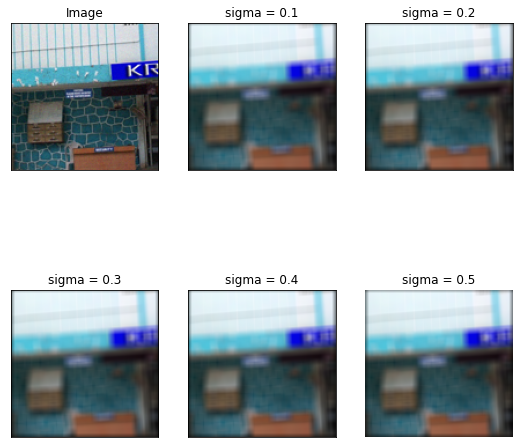

In [11]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(9,9))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])

ax1.imshow(krishna_noisy*1/np.max(krishna_noisy), 'gray')
ax1.title.set_text('Image')
ax2.imshow(krishna_NLM_filtered[0.1]*1/np.max(krishna_NLM_filtered[0.1]), 'gray')
ax2.title.set_text('sigma = 0.1')
ax3.imshow(krishna_NLM_filtered[0.2]*1/np.max(krishna_NLM_filtered[0.2]), 'gray')
ax3.title.set_text('sigma = 0.2')
ax4.imshow(krishna_NLM_filtered[0.3]*1/np.max(krishna_NLM_filtered[0.3]), 'gray')
ax4.title.set_text('sigma = 0.3')
ax5.imshow(krishna_NLM_filtered[0.4]*1/np.max(krishna_NLM_filtered[0.4]), 'gray')
ax5.title.set_text('sigma = 0.4')
ax6.imshow(krishna_NLM_filtered[0.5]*1/np.max(krishna_NLM_filtered[0.5]), 'gray')
ax6.title.set_text('sigma = 0.5')

plt.axis('off')
plt.show()

# Gaussian Blurring: Space Invariant blur

In [13]:
def Gaussian_blurring(sigma,img):
    
    # Get kernel size
    kernel_size = math.ceil(6*sigma+1)
    
    # We ensure that the kernel is odd sized
    if (kernel_size%2)==0 :
        kernel_size = kernel_size + 1
    d = (kernel_size)//2
    
    # If the kernel size is 1, the resultant blurring is none. The original image can be returned
    if kernel_size == 1:
        return img
    
    # Get blur kernel
    blur_kernel = np.zeros((kernel_size,kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    
    # Perform blurring
    # Get image shape
    [x,y,z] = np.shape(img)
    blurred_image_3D = np.zeros((x,y,z))
    for k in range(z):
        # Create blur image
        blurred_image = np.zeros((x,y))
        for i in range(x):
            for j in range(y):

                # We ensure that the blur kernel is accordingly sized for pixels along the borders as well
                if i<d:
                    i_start = 1
                    i_end = i+d
                    kernel_i_start = d-i+2
                    kernel_i_end = 2*d+1
                elif i>x-d :
                    i_start = i-d
                    i_end = x
                    kernel_i_start = 1
                    kernel_i_end = x-i+d+1
                else :
                    i_start = i-d
                    i_end = i+d
                    kernel_i_start = 1
                    kernel_i_end = 2*d+1
                if j<d:
                    j_start = 1
                    j_end = j+d
                    kernel_j_start = d-j+2
                    kernel_j_end = 2*d+1
                elif j>y-d :
                    j_start = j-d
                    j_end = y
                    kernel_j_start = 1
                    kernel_j_end = y-j+d+1
                else :
                    j_start = j-d
                    j_end = j+d
                    kernel_j_start = 1
                    kernel_j_end = 2*d+1

                # Get the patch of image on which blurring is done
                patch = img[i_start:i_end, j_start:j_end]

                # Get the resized, normalised kernel for the patch
                kernel = blur_kernel[kernel_i_start:kernel_i_end,kernel_j_start:kernel_j_end]/np.sum(blur_kernel[kernel_i_start:kernel_i_end,kernel_j_start:kernel_j_end])

                # Blurred pixed value
                blurred_image[i, j] = np.sum(kernel*patch)
        blurred_image_3D[:,:,k] = blurred_image
    # Return blurred image
    return blurred_image_3D

In [13]:
display(PSNR_NLM_W3)

{0.1: 5.430901617305465,
 0.4: 5.43077607582103,
 0.2: 5.430775583504937,
 0.3: 5.430775581574285,
 0.5: 5.4307755815667145}